# **1 - Illustrative case study**

# Regression with artificial neural networks in PyTorch

An artificial neural network (ANN) is an universal function approximator. Contrary to curve-fitting regression, ANNs have the advantage that no a priori knowledge of the process is needed. Here we show an example of a simple ANN to approximate its target distribution. For the demonstration we use the programming language Python since it is the most popular machine learning language and offers a large and active developer community.

Opposite to matlab, we do not have all functionalities pre installed in Python. Therefore, the first step for a project is always to install packages which extend our function library. Here, we install the following packages:
- *torch*: The PyTorch package is the most important one for this lab and inherits a variety of useful functions for machine learning.
- *matplotlib*: Provides plotting functions similar to matlab.
- *tqdm*: Allows to print progress bar of for loops

Here we use [PyTorch](https://pytorch.org/) to work with neural networks. Pytorch is an open source machine learning framework with many predefined functions which make the work with machine learning way easier. You can learn pytorch from the [tutorial link](https://pytorch.org/tutorials/). The Docs information can be searched at [Docs](https://pytorch.org/docs/stable/index.html). A popular alternative to Pytorch is Keras (building on Tensorflow). *optim* is a library of optimizers for the backpropagation.

In [52]:
# install dependencies
!pip install torch
!pip install matplotlib
!pip install tqdm

You should consider upgrading via the 'c:\users\lschulzebalhor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\lschulzebalhor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\lschulzebalhor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


## 1.1 - Python preparation

### Import packages

In the next step, we import the previously installed packages into our script.

In [53]:
import numpy as np  # numerical calculations in python
import matplotlib.pyplot as plt  # plotting similar to matlab
import torch  # PyTorch: the general machine learning framework in Python
import torch.optim as optim  # contains optimizers for the backpropagation
import torch.nn as nn  # the artificial neural network module in PyTorch
from tqdm import tqdm  # produces progress bars for for-loops in Python
from sklearn.model_selection import train_test_split  # randomly splits a dataset

### Set the seed

To make our results reproducable, we need to set a so-called "seed". Machine Learning includes stochastic processes in the weight/bias initialization and the backpropagation. Also the random number generation which we will use for the dataset is a stochastic process. By setting a seed in the program we make sure that always the same random numbers are chosen. Otherwise, we would get different results everytime we run this script, which is not nice for teaching purposes.

In [54]:
torch.manual_seed(0)
np.random.seed(0)

## 1.2 - Prepare datasets

First and foremost, we need a dataset to work on. Here, we simply make up our dataset from a self defined model.

Now we define the model which we want to approximate. We add the option to add some noise to the output.

In [257]:
# model definition
def model(x, noise=False):
    y = np.sin(x)+np.sin(10/3*x) # model function
    if noise:
        y += 0.3*(np.random.uniform(-1, 1, x.size)) # add noise if noise=True
    return y # return output

We use our model to generate a dataset.

In [862]:
n = 100 # number of data points
xmin = 2 # minimum value
xmax = 6 # maximum value
x = np.linspace(xmin, xmax, n) # generate equally spaced input values
y = model(x, noise=True) # get output from our model with noise

For a better understanding of the data set we plot it with matplotlib.

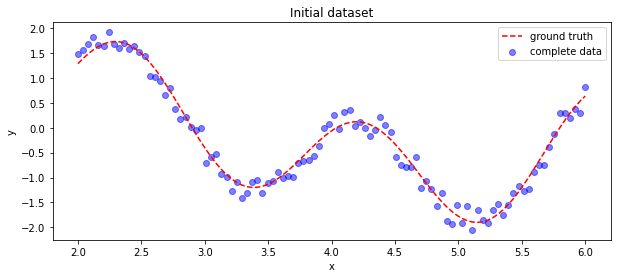

In [863]:
plt.figure(figsize=(10,4)) # define figure size
plt.plot(x, model(x), color='r', linestyle='--', label='ground truth')
plt.scatter(x, y, alpha=0.5, color='b', label='complete data') # scattered plot
plt.title('Initial dataset') # add plot title
plt.xlabel('x') # add x axis label
plt.ylabel('y') # add y axis label
plt.legend() # add plot legend
plt.show()

We need to split the dataset in training, validation and test data. In the first step we will split the data in training and remaining dataset. Now since we want the valation and test size to be equal (10% each of overall data), we have to define *train_size=0.5* (that is 50% of remaining data).

In [864]:
# first split
x_train, x_rem, y_train, y_rem = train_test_split(x, y, train_size=0.7)

# second split
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, test_size=0.5)

We also plot the dataset division.

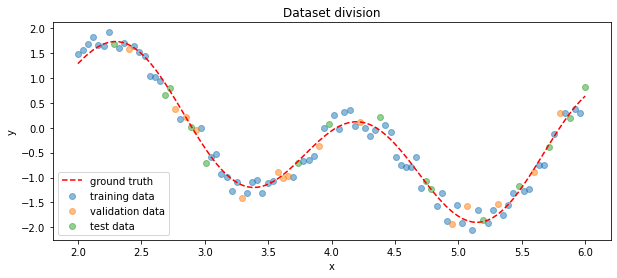

In [865]:
plt.figure(figsize=(10,4)) # define figure size
plt.plot(x, model(x), color='r', linestyle='--', label='ground truth') # line plot
plt.scatter(x_train, y_train, alpha=0.5, label='training data') # scattered plot
plt.scatter(x_val, y_val, alpha=0.5, label='validation data') # scattered plot
plt.scatter(x_test, y_test, alpha=0.5, label='test data') # scattered plot
plt.title('Dataset division') # add plot title
plt.xlabel('x') # add x axis label
plt.ylabel('y') # add y axis label
plt.legend() # add plot legend
plt.show()

So far our datasets are stored in numpy arrays. However, PyTorch works with tensors instead of arrays and we need to transform our data. [Here](https://medium.com/@quantumsteinke/whats-the-difference-between-a-matrix-and-a-tensor-4505fbdc576c) you can find a blog post discussing the differences. We need to do two small technical changes as well. Numpy arrays usually use the double/float64 datatype whereas PyTorch uses float/float32. Therefore, we change the datatype *dtype*. In addition, we have to change the shape of the tensor from (#data) to (#data,1) with *unsqueeze*.

In [866]:
xt_train = torch.tensor(x_train, dtype=torch.float).unsqueeze(-1)
xt_val = torch.tensor(x_val, dtype=torch.float).unsqueeze(-1)
xt_test = torch.tensor(x_test, dtype=torch.float).unsqueeze(-1)
yt_train = torch.tensor(y_train, dtype=torch.float).unsqueeze(-1)
yt_val = torch.tensor(y_val, dtype=torch.float).unsqueeze(-1)
yt_test = torch.tensor(y_test, dtype=torch.float).unsqueeze(-1)

## 1.3 - Set up ANN

Besides the data we also nee to prepare our ANN. The *nn.Module* is the standard class for an ANN in PyTorch. The abbreviation *nn* stands for neural network. We build a child class of it where we specify our desired model architecture. Pytorch uses a base model object and adds the layers and activations as other objects in a sequential manner. The first layer must get an input dimensions matching the data, whereas the following can deduce their input size from the previous layer. The output layer then must match the dimension of the target values. Each ANN class needs a *forward* function which defines, how a signal propagates through the network.

In [867]:
# neural network definition
class NeuralNetwork(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(NeuralNetwork, self).__init__()
        self.architecture = nn.Sequential( 
            # sequential model definition: add up layers & activation functions
            nn.Linear(in_features=n_input, out_features=n_hidden, bias=True),  # hidden layer
            nn.Tanh(), # activation function
            nn.Linear(in_features=n_hidden, out_features=n_hidden, bias=True),  # hidden layer
            nn.Tanh(), # activation function
            nn.Linear(in_features=n_hidden, out_features=n_output, bias=True)   # output layer
        )
    def forward(self, input): # feed forward path
        output = self.architecture(input)
        return output

## 1.4 - Train ANN

Now the fun begins. We put the dataset and ANN architecture together to "train" our ANN.

We use the training data to train our neural network. This process is nothing else then optimizing the weights and biases in our network. Before starting the training process, we need to define a few things:
- *optimizer*: Here we use *SGD* which stands for [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). With the optimizer, we also need to define the learning rate *lr*. It determines how fast we adopt the weights and biases during the training. If it is too high, the learning becomes instable and the loss increases. If it is too low, we need to many epochs and we do not reach a satisfying precision.
- *loss function*: This is the objective of our training/optimization. For continuous outputs as in our example, you usually use the mean squared error. For discrete outputs, another function is needed, like the cross entropy.
- *epochs*: How often do we want to repeat the training with our dataset?

Optimizing these parameters is called hyerparameter tuning.

---
**Adjust the following hyperparameters to find the optimal combination:**

In [884]:
hidden_size = 20 # number of neurons in the hidden layer
learning_rate = 0.09 # learning rate for the backpropagation

*hidden_size* $\in[1, 1024]$

*learning_rate* $\in(0, 1]$

Please report the results which are printed below (after the loss plot) for comparison via this form: https://forms.gle/vg4hJAmBSqgzspBf6. You can view the results in this sheet: https://docs.google.com/spreadsheets/d/1Rzf1-g-QX_2QRsPoFU0Xw1UYO5OKrO4ebMfN6KfJxS4/edit?usp=sharing.

---

The following cell prepares everything for the training.

In [885]:
# neural network training
net = NeuralNetwork(1, hidden_size, 1) # create instance of neural network
optimizer = optim.SGD(net.parameters(), lr=learning_rate) # choose optimizer and learning rate
loss_fun = nn.MSELoss() # define loss function
epochs = 5000 # set number of epochs
net

NeuralNetwork(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)

This is the main part of using an ANN: the actual "training". We give an input to the network and see how the output differs from our expected output. The difference is used to calculate the loss. Then we update the weights and biases such that the loss will be smaller in the next epoch.

In the training process we use two datasets: the **training** and the **validation** data. The training data are used to calculate the training loss, which is then used for the backpropagation and the network update. The validation data are used to detect overfitting. We just calculate the loss for the validation data, but do not use it for the backpropagation. If the training and the validation loss diverge, we know that the network updates do not generalize for unseen data.

In [886]:
train_loss = []
val_loss = []

# train the network
for epoch in tqdm(range(epochs)):
    
    # training data
    optimizer.zero_grad() # clear gradients for next training epoch
    y_pred = net(xt_train) # forward pass: prediction y based on input x
    loss = loss_fun(y_pred, yt_train)  # compare true y and predicted y to get the loss
    loss.backward() # backpropagation, compute gradients
    optimizer.step() # apply gradients to update weights and biases
    train_loss.append(loss.item()) # save loss for later evaluation

    # validation data
    loss = loss_fun(y_pred, yt_train) # compare true y and predicted y to get the loss
    val_loss.append(loss.item()) # save loss for later evaluation

100%|██████████| 5000/5000 [00:01<00:00, 3750.30it/s]


 Afterwards, we plot the loss to see the training progress. The loss plot shows if adjustments need to be made to the hyperparameters.

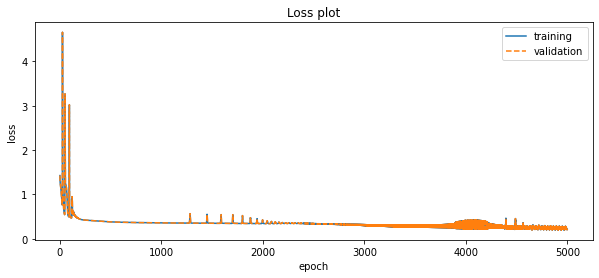

Final training loss: 
0.21139471232891083


In [887]:
plt.figure(figsize=(10,4))
plt.plot(train_loss, label='training')
plt.plot(val_loss, label='validation', linestyle='--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss plot')
plt.show()
print('Final training loss: ')
print(train_loss[-1])

---
Now you can play around with the hyperparameters *hidden_size* and *learning_rate* to get a feeling how they affect the prediction quality. The following cell summarizes the results:

In [888]:
print('Hidden layer size: ', hidden_size)
print('Learning rate: ', learning_rate)
print('Validation MSE: ', val_loss[-1]) # last element from the validation loss

Hidden layer size:  20
Learning rate:  0.09
Validation MSE:  0.21139471232891083


---

## 1.5 - Evaluate ANN

Now we evaluate the trained ANN by using it to predict our known data.

In [889]:
# neural network evaluation
with torch.no_grad():
    y_pred = net(torch.Tensor(x).unsqueeze(-1))

For a first qualitative evaluation we plot both actual test output data and the prediction by the ANN on the test set. We can play around with the hyperparameters and see how they affect the prediction quality.

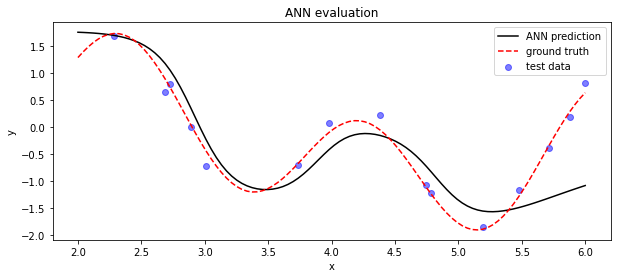

In [890]:
plt.figure(figsize=(10,4))
plt.plot(x, y_pred, color='k', label='ANN prediction')
plt.plot(x, model(x), color='r', linestyle='--', label='ground truth')
plt.scatter(x_test, y_test, alpha=0.5, color='b', label='test data')
plt.title('ANN evaluation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## 1.6 - Discussion

#### Quantitative assessment

We were a little loose here by relying on a visual assessment of the fit. To systematically improve it we need a quantitative analysis of the errors. Therefore, we evaluate the mean squared error *MSE* of the test predictions.

$MSE = \frac{1}{n}\sum_{i=1}^n{(Y_i-\hat{Y}_i)^2}$

For this we use the feed forward function of the ANN and get the prediction for the different datasets.

In [891]:
# neural network
with torch.no_grad():
    y_pred_train = net(xt_train)
    y_pred_val = net(xt_val)
    y_pred_test = net(xt_test)

The .item() method converts single element tensors to Python scalers for printing.

Training mean squared error:

In [892]:
torch.mean(( yt_train - y_pred_train )**2).item()

0.2013700008392334

Validation mean squared error:

In [893]:
torch.mean(( yt_val - y_pred_val )**2).item()

0.25745680928230286

Test mean squared error:

In [894]:
torch.mean(( yt_test - y_pred_test )**2).item()

0.5248106718063354

Another way to evaluate the model accuracy is to use a Pareto chart. In a Pareto chart, the ground truth is compared to the prediction. Ideally, the points should lay on the solid diagonal. The dashed lines show the 10% error interval.

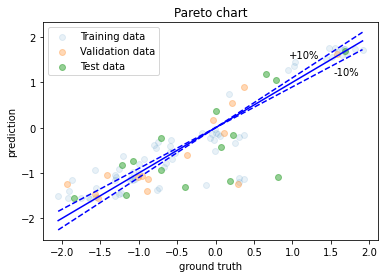

In [895]:
plt.scatter(y_train, y_pred_train, alpha=0.1, label="Training data")
plt.scatter(y_val, y_pred_val, alpha=0.3, label="Validation data")
plt.scatter(y_test, y_pred_test, alpha=0.5, label="Test data")
plt.legend()
plt.xlabel('ground truth')
plt.ylabel('prediction')
min = np.min(y)
max = np.max(y)
plt.plot([min, max], [min, max], c="b")
plt.plot([min, max], [0.9*min, 0.9*max], c="b", linestyle='--')
plt.plot([min, max], [1.1*min, 1.1*max], c="b", linestyle='--')
plt.text(0.8*max, 0.6*max, '-10%')
plt.text(0.5*max, 0.8*max, '+10%')
plt.title('Pareto chart')
plt.show()

#### Interpolation vs. Extrapolation

One important point to keep in mind is that purely data driven models cannot extrapolate. We see this in the following example. We increase the data range by 50% in both directions.

In [896]:
x_ext = np.linspace(np.min(x)-abs(x[-1]-x[0])/2, np.max(x)+abs(x[-1]-x[0])/2, 100)

Again, in order to work with PyTorch we transform our array to a tensor.

In [897]:
xt_ext = torch.tensor(x_ext, dtype=torch.float).unsqueeze(-1)

Now we use the trained model to predict values outside the training range.

In [898]:
# neural network evaluation
with torch.no_grad():
    y_pred_ext = net(xt_ext)

We plot the ANN regression. The vertical bars mark the border of the training range.

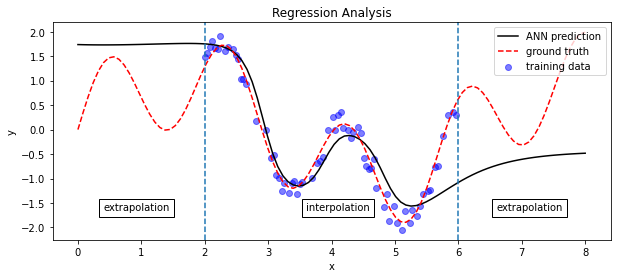

In [899]:
plt.figure(figsize=(10,4))
plt.text(np.mean(x)-0.1*abs((np.max(x)-np.min(x))), np.min(y)+0.1*abs((np.max(y)-np.min(y))), 'interpolation', bbox=dict(facecolor = 'w'))
plt.text(np.min(x)-0.8*abs((np.min(x_ext)-np.min(x))), np.min(y)+0.1*abs((np.max(y)-np.min(y))), 'extrapolation', bbox=dict(facecolor = 'w'))
plt.text(np.max(x)+0.3*abs((np.max(x_ext)-np.max(x))), np.min(y)+0.1*abs((np.max(y)-np.min(y))), 'extrapolation', bbox=dict(facecolor = 'w'))
plt.plot(x_ext, y_pred_ext, color='k', label='ANN prediction')
plt.plot(x_ext, model(x_ext), color='r', label='ground truth', linestyle='--')
plt.scatter(x_train, y_train, alpha=0.5, color='b', label='training data')
plt.axvline(np.min(x), linestyle='--')
plt.axvline(np.max(x), linestyle='--')
plt.title('Regression Analysis')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.show()

In the plot we clearly see that the neural network is not able to extrapolate.

## 1.7 - Conclusion

In the first half of the lab we demonstrated how to use an ANN for regression. We introduced the key parameters to train an ANN and experienced, how they affect the training process. We also discussed extrapolation as a shortcoming of ANNs. Maybe you also experienced overfitting during your hyperparameter tuning?

We hope you enjoyed it!